In [1]:
#import numpy as np
#import matplotlib.pyplot as plt
from qcodes.dataset.data_export import load_by_id #, get_data_by_id
from qcodes.dataset.plotting import plot_by_id

from qdev_wrappers.automated_tuneup.cavity_sweep import get_pushed_cavity_settings
from qdev_wrappers.automated_tuneup.spectroscopy import find_peaks
#from qdev_wrappers.fitting.fitter import Fitter
#from qdev_wrappers.fitting.models import SimpleMinimum

from qdev_wrappers.optimization.method import make_optimization_method
from qdev_wrappers.optimization.search_methods import BestNeighbour
from qdev_wrappers.optimization.measurement_methods import ReadoutFidelityOptimization, Rabis
from qdev_wrappers.optimization.optimization_from_completed_data import get_measured_data

/anaconda3/envs/qcodes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/Lillian/qdev-wrappers/qdev_wrappers/logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '


## Finding the cavity

Cavity push from saved data takes:  
    **runid**  
    **power_start** (default -10 dBm)  
    **power_stop** (default -45 dBm)  
    **power_step** (how much to go down in power each iteration, default 5 dBm)  
      
If it were taking data, it would not need the runid, but would instead need:  
    **guess**: frequency to center the sweep around  
    **cavity**: cavity instrument  
    **pwa**: pwa instrument  
      
Its current stop criteria is: push up of more than 0.5 MHz and a slope of with a magnitude of less than 0.05 MHz/dBm

Pushed cavity: (-35.0, 6989623333.33333)
Unpushed cavity: (-10.0, 6988423333.33333)
Push: 1.2 MHz


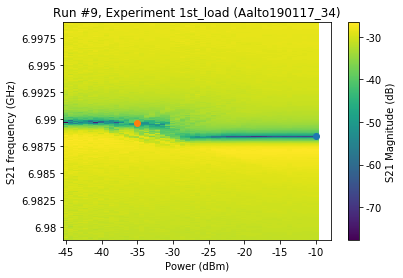

In [2]:
cav_freq, push = get_pushed_cavity_settings(runid=9)

Pushed cavity: (-43.0612244897959, 6988800000.0)
Unpushed cavity: (-10.0, 6983000000.0)
Push: 5.8 MHz


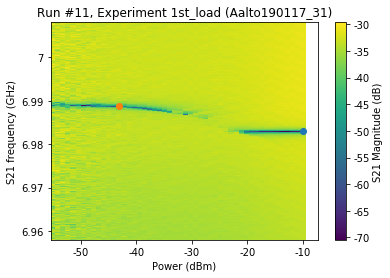

In [3]:
cav_freq, push = get_pushed_cavity_settings(runid=11, power_stop=-55, power_step=3)

## Spectroscopy

Spectroscopy uses "find_peaks" function to identify peaks in the data, by first deciding on a noise floor threshhold, and then looking for anything beyond the threshhold. This can also be run on completed data. It takes both phase and magnitude data, and considers anything that exceed 3 standard deviations from the mean "noise floor" in both phase and magnitude to be part of a peak.

It returns a list of frequeny locations for the peaks, a list of magnitudes, and a list of widths.


#### Not currently  set up to run from saved data:

When it is measuring, it would run *find_and_verify_peaks* instead, which calls *find_peaks*, and, if it finds anything, calls *find_peaks* again and compares the results, to verify that it has identified a consistent feature. It then returns a list of tuples *(f, m, w)*, with the frequency, magnitude and width of each of the verified peaks.

Additionally, when measuring, it would run look_for_qubit, which starts at a guess frequency (default: 5 GHz), and calls *find_and_verify_peaks*. It then responds based on how many peaks it measures:
  
*No peaks*: move on  
*Many peaks*: turn down power  
*Few peaks*: upload rabi sequence and check for oscialltions at the peak frequencies


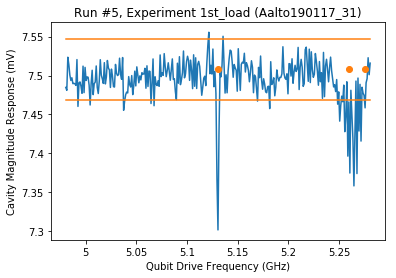

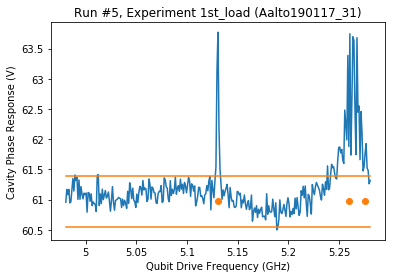

In [5]:
freqs, mags, widths = find_peaks(runid=5, plot=True)

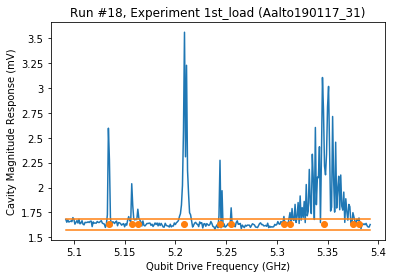

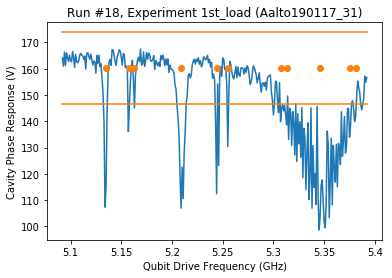

In [6]:
# at high power
freqs, mags, widths = find_peaks(runid=18, plot=True)

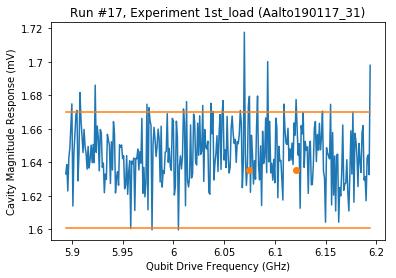

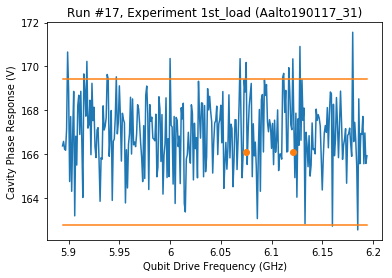

In [7]:
# just noise
# this is why find_and_verify_peaks is used to reject peaks that are not consistently present at a given frequency
freqs, mags, widths = find_peaks(runid=17, plot=True)

## Frequency center based on rabis

Minimizes cost function *cost_val = 1/pi_pulse_duration*

Can also adjust power, minimizing the cost function *cost_val = abs(50e-9 - pi_pulse_duration)*

The optimization is performed using a method that combines a measurement method (what to measure, how to analyse the data, stopping condtions and cost value function) and a search method (how to move in parameter space while optimizing). 

It also needs a function to use to get the data. For data from completed datasets, this is *get_measured_data*. It might otherwise be, for example, *pwa.alazar_channels.data*.

The default max_attempts is 20. 

In [8]:
rabi_optimizer = make_optimization_method(Rabis, BestNeighbour, get_measured_data, max_attempts=10)

A start location currently needs to be specified to optimize based on completed data. When optimizing and measuring at the same time, it starts from the current settings for the parameter.

Calling 'optimize' from the method takes:  
**parameters**: From completed data, this is the name of the parameter in the dataset. For measuring and optimizing, it is fx. qubit.frequency  
**step size**  
**start**  
**runid**  
  
It returns an "optimization", which is currently an object that stores information about the optimization results as its attributes.

In [9]:
start = {'rs_qubit_frequency': 5.35e9}
opt_rabis = rabi_optimizer.optimize('rs_qubit_frequency', 0.5e6, start=start, runid=6)

Starting experimental run with id: 63
Best: {'rs_qubit_frequency': 5343000000.0, 'pi_pulse_duration': 8.142192447302597e-08}


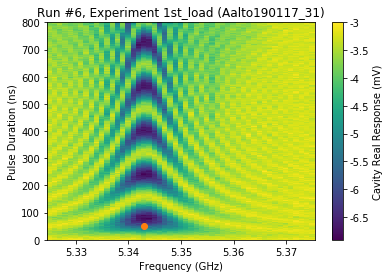

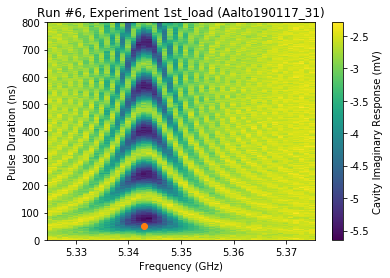

In [10]:
ax, clb = plot_by_id(6)
ax[0].scatter(opt_rabis.best['rs_qubit_frequency'], 50e-9, color='C1')
ax[1].scatter(opt_rabis.best['rs_qubit_frequency'], 50e-9, color='C1')

([<matplotlib.axes._subplots.AxesSubplot at 0x11f839c88>], [None])

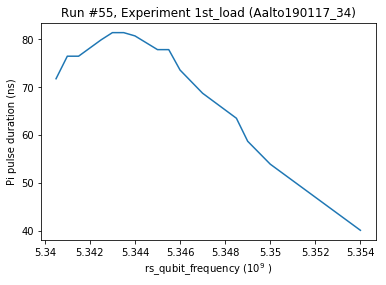

In [11]:
# What it saved while optimizing
plot_by_id(55)

## Optimization based on readout fidelity

Optimization based on readout fidelity works pretty much the same way as with rabis, but now with a new meausurement method:

In [12]:
readout_fid_optimizer = make_optimization_method(ReadoutFidelityOptimization, BestNeighbour, get_measured_data)

([<matplotlib.axes._subplots.AxesSubplot at 0x11b9657f0>],
 [<matplotlib.colorbar.Colorbar at 0x11b98d518>])

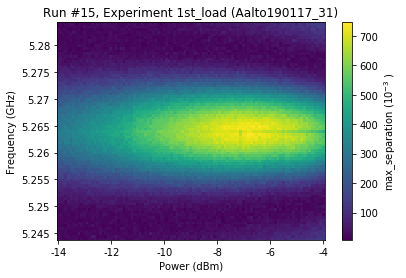

In [13]:
# this is the dataset
plot_by_id(15)

The default parameter name for readout fidelity is 'readout_fidelity', but in the datset, the parameter is named 'max_separation'. This should probably be easier to change than it currently it, but here I'm going to change it like this:

In [14]:
readout_fid_optimizer.measured_params = {'max_separation': {'label': 'Readout Fidelity', 'unit': ''}}

The next part is the same as with rabis. It takes the parameters and step sizes, as well as start and runid:

In [15]:
start = {'rs_qubit_frequency': 5.255e9, 'rs_qubit_power':-6}
opt = readout_fid_optimizer.optimize('rs_qubit_frequency', 0.5e6, 'rs_qubit_power', 0.1, start=start, runid=15)

Starting experimental run with id: 64
Best: {'rs_qubit_frequency': 5263500000.0, 'rs_qubit_power': -6.7, 'max_separation': array([0.74133333])}


This results in something like this being saved:

([<matplotlib.axes._subplots.AxesSubplot at 0x11bac3e10>],
 [<matplotlib.colorbar.Colorbar at 0x112e9f390>])

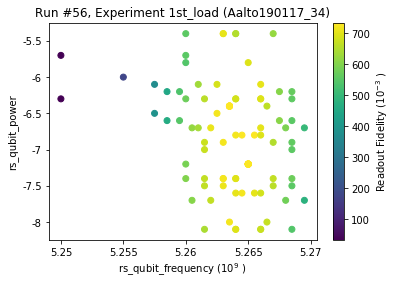

In [16]:
plot_by_id(56)

The 'optimizer' can also optimize cavity drive and frequency, by giving it different parameters (and in the case of plotting from measured dataset, a different start and run id):

([<matplotlib.axes._subplots.AxesSubplot at 0x11baa4240>],
 [<matplotlib.colorbar.Colorbar at 0x11fe46438>])

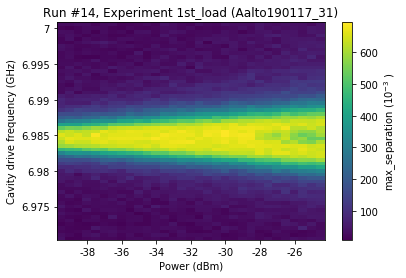

In [17]:
plot_by_id(14)

In [18]:
start = {'cavity_drive_frequency': 6.98e9, 'rs_alazar_power':-38}
opt = readout_fid_optimizer.optimize('cavity_drive_frequency', 0.5e6, 'rs_alazar_power', 0.1, start=start, runid=13)

Starting experimental run with id: 65
Best: {'cavity_drive_frequency': 6985000000.0, 'rs_alazar_power': -38.00000000000001, 'max_separation': array([0.672])}


([<matplotlib.axes._subplots.AxesSubplot at 0x11f549e48>],
 [<matplotlib.colorbar.Colorbar at 0x120381048>])

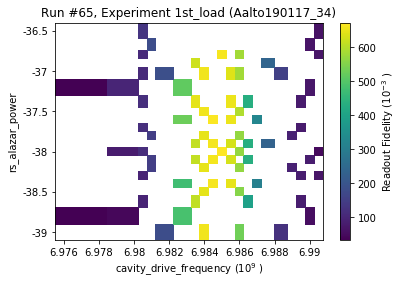

In [19]:
plot_by_id(65)